In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import util
import scanpy as sc
import tifffile
from skimage.filters import threshold_otsu
import os

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import rc_context

from joblib import Parallel, delayed
from tqdm import tqdm

In [5]:
scale = 249.6/2304
z_scale = 0.3/1

# Clustering of patches by proximity score

In [61]:
cell_df = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df\bm_007_13.csv',index_col=0)

In [62]:
proximity = pd.read_pickle(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\networks\proximity_scores\networks\bm_007_13.pkl')

In [63]:
genes = np.sort(cell_df['gene'].unique())

In [22]:
pairs = []
for g1 in genes:
    for g2 in genes:
        if (not g1 + '_' + g2 in pairs) and (not g2 + '_' + g1 in pairs):
            pairs.append(g1 + '_' + g2)

In [25]:
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df'
cells_l = os.listdir(cell_df_dir)
cells_l.sort()

proximity_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\networks\proximity_scores\networks'

In [34]:
proxi_data = []
patch_id = []
for cell in tqdm(cells_l):
    if cell.endswith('.csv'):
        cell_df = pd.read_csv(os.path.join(cell_df_dir,cell))
        name = cell.split('.')[0]
        proximities = pd.read_pickle(os.path.join(proximity_dir,name+'.pkl'))
        patches = np.sort(cell_df['patch'].unique())
        proxi = np.zeros((patches.shape[0],len(pairs)))
        for p in patches:
            proximity_df = proximities[p][0]
            for i,pair in enumerate(pairs):
                [g1,g2] = pair.split('_')
                if g1 in proximity_df.columns.tolist() and g2 in proximity_df.columns.tolist():
                    proxi[p,i] = proximity_df.loc[g1,g2]
            patch_id.append(name+'_'+str(p))
        proxi_data.append(proxi)

100%|████████████████████████████████████████████████████████████████████████████████| 554/554 [02:12<00:00,  4.17it/s]


In [35]:
proxi_data = np.concatenate(proxi_data,axis=0)

In [37]:
proxi_df = pd.DataFrame(proxi_data,columns=pairs,index=patch_id)

In [46]:
proxi_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [47]:
proxi_df.dropna(axis=1,inplace=True)

In [48]:
cell_types = ['']*len(patch_id)
for i,p in enumerate(patch_id):
    cell_types[i] = 'H' + p.split('_')[0].upper()
cell_types = pd.Categorical(cell_types,ordered=True, categories=['HBM','HUC'])

In [50]:
proxi_adata = sc.AnnData(proxi_df.values)
proxi_adata.var_names = proxi_df.columns.tolist()
proxi_adata.obs['patch_id'] = patch_id
proxi_adata.obs['cell_types'] = cell_types
proxi_adata.uns['cell_types_colors'] = ['#0000ff', '#ff0000']

In [51]:
sc.pp.neighbors(proxi_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [53]:
sc.tl.tsne(proxi_adata)
sc.tl.umap(proxi_adata)

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [56]:
sc.tl.leiden(proxi_adata,resolution=0.5)

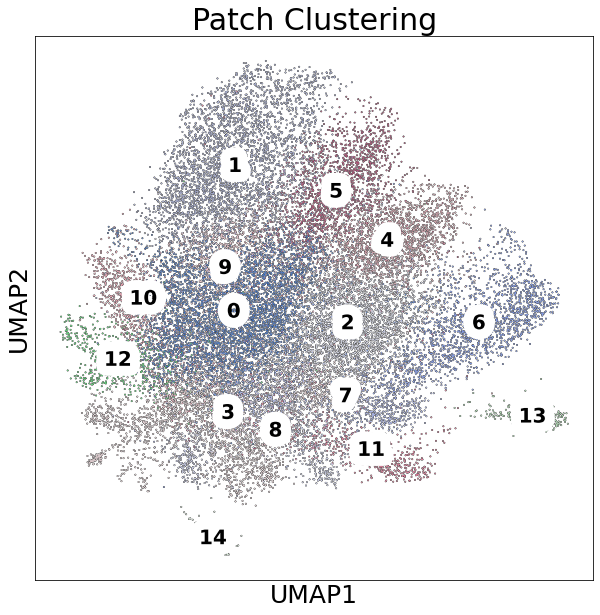

In [631]:
with rc_context({'figure.figsize':(10, 10), 'font.size':25}):
    sc.pl.umap(proxi_adata, color=['leiden'], size=5, 
               legend_loc='on data', add_outline=True, 
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Patch Clustering')
               # save=' hydrogel_network_variability_patch_clustering.png')

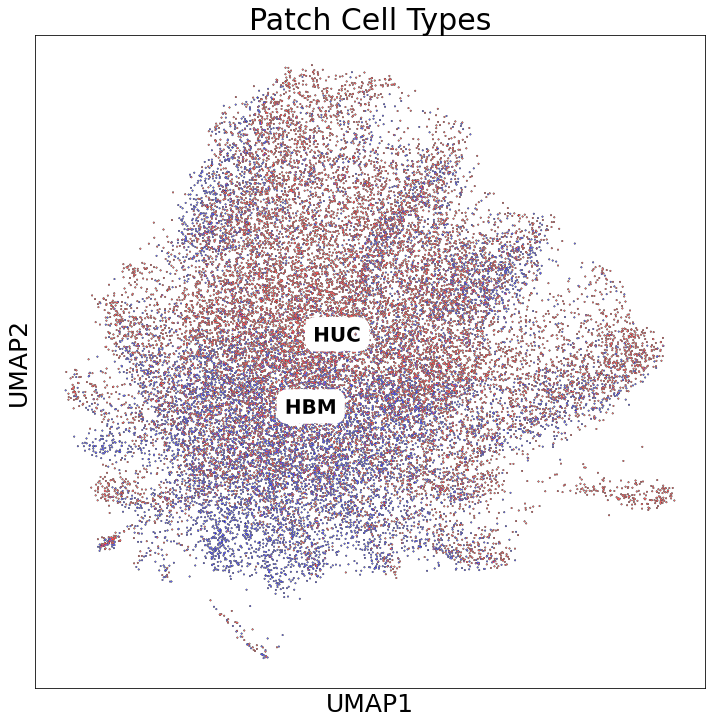

In [632]:
with rc_context({'figure.figsize':(12, 12), 'font.size':25}):
    sc.pl.umap(proxi_adata, color=['cell_types'], size=5, 
               legend_loc='on data', add_outline=True, 
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Patch Cell Types')
               # save=' hydrogel_network_variability_patch_cellTypes.png')

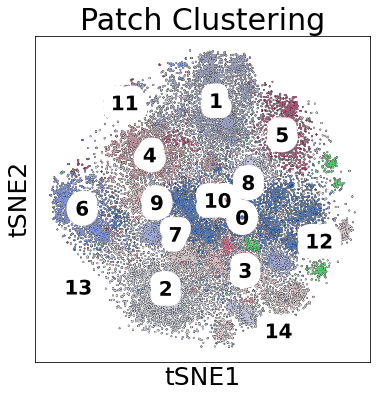

In [69]:
with rc_context({'figure.figsize':(6, 6), 'font.size':25}):
    sc.pl.tsne(proxi_adata, color=['leiden'], size=5, 
               legend_loc='on data', add_outline=True, 
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Patch Clustering',
               save=' hydrogel_network_variability_patch_clustering.png')

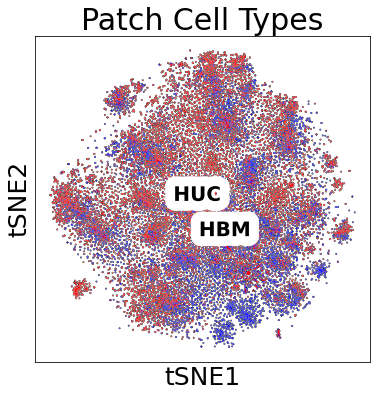

In [70]:
with rc_context({'figure.figsize':(6, 6), 'font.size':25}):
    sc.pl.tsne(proxi_adata, color=['cell_types'], size=5, 
               legend_loc='on data', add_outline=True, 
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Patch Cell Types',
               save=' hydrogel_network_variability_patch_cellTypes.png')

In [71]:
proxi_adata.write_h5ad(r'.\results\proxi_adata.h5ad')

In [76]:
proxi_df.insert(loc=proxi_df.shape[1],column='cluster',value=proxi_adata.obs['leiden'].astype('int').tolist())

In [78]:
proxi_df.to_csv(r'.\results\proxi_df')

# Plot bm cell patch cluster example

## Get dapi image for the cell

In [11]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\masks\007_mask.tif')
mask = (mask==13).astype('int')

In [12]:
dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\imgs\007_image.tif')
dapi_mip = dapi_mip[2,:,:]

In [13]:
masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

In [14]:
dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

In [15]:
dapi_z = 12 * z_scale

## Load data and plot

In [6]:
bm_cell_df = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df\bm_007_13.csv',index_col=0)
bm_cell_adata = sc.read_h5ad(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_adata\bm_007_13.h5ad')

In [7]:
colors = bm_cell_adata.uns['leiden_colors']

In [8]:
bm_by_patch = bm_cell_df.groupby('patch')

### Raw rna plots

In [64]:
gene_color_dict = {'ACAN':'#ffffff', 'ACTb':'#b60000', 'ALPL':'#008c00', 'CCL11':'#c34fff',
                   'CCL19':'#01a5ca', 'CD105':'#ec9d00', 'CD11B':'#76ff00', 'CD19':'#ff7598',
                   'CD34':'#940073', 'CD45':'#00f3cc', 'CD79B':'#4853ff', 'CD90':'#a6a19a',
                   'COL1A1':'#edb7ff', 'COL2A1':'#8a6800', 'COL5A2':'#6100a3', 'COMP':'#fff585',
                   'CXCR4':'#007b69', 'EEF2':'#92b853', 'GAPDH':'#abd4ff', 'HLA-DRA':'#7e79a3',
                   'IBSP':'#ff5401', 'IL6':'#0a577d', 'IL8':'#a8615c', 'MALAT1':'#e700b9',
                   'MKI67':'#ffc3a6', 'NANOG':'#00b485', 'PDL1':'#7e9eff', 'PTH1R':'#b8d8b7',
                   'RUNX1':'#c082b7', 'SOX9':'#6f895b', 'SPP1':'#8a48a2'}

In [65]:
bm_by_gene = bm_cell_df.groupby('gene')

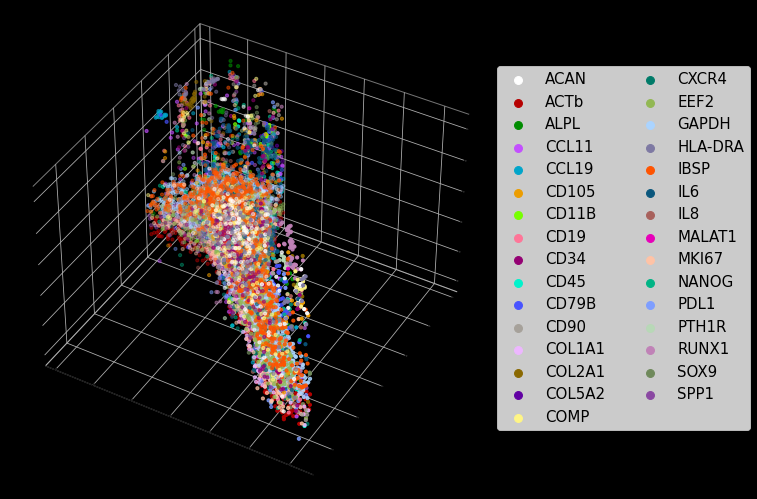

In [66]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
for g in genes:
    sub_group = bm_by_gene.get_group(g)
    c = gene_color_dict[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=10,label=g)
ax.view_init(-140, 60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()

plt.savefig(r'.\figures\bm_007_13_raw_rna_2 col legend.png',dpi=300)

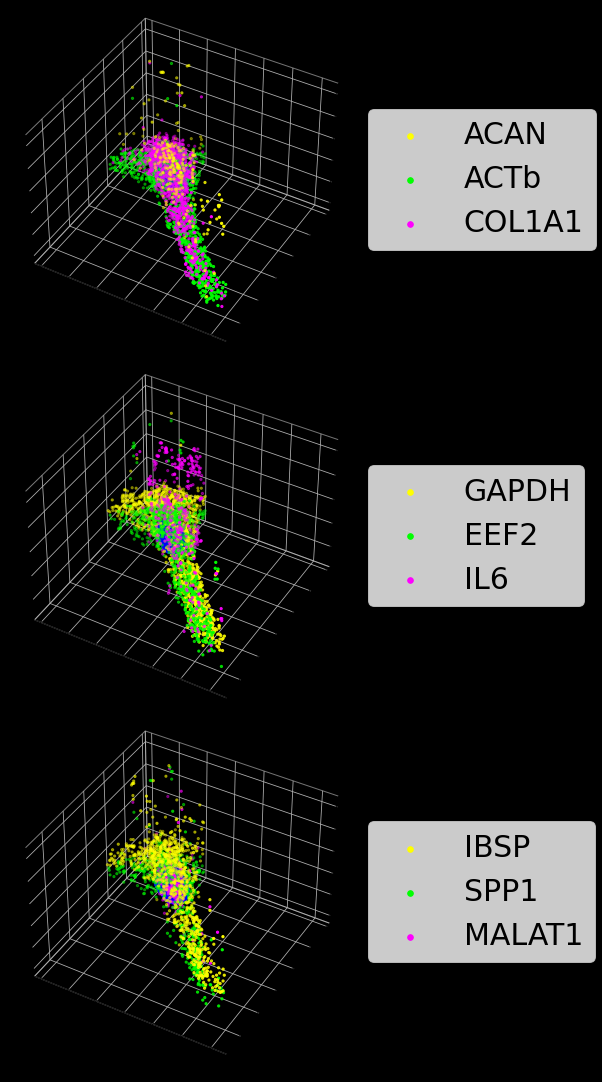

In [37]:
# subset of gnes
gene_sets = [['ACAN','ACTb','COL1A1'],['GAPDH','EEF2','IL6'],['IBSP','SPP1','MALAT1']]

fig = plt.figure(figsize=(15,15))
for i,item in enumerate(gene_sets):
    ax = fig.add_subplot(3,1,i+1,projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()
    
    ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
    
    sub_group = bm_by_gene.get_group(item[0])
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale
               ,sub_group['z']*z_scale,'.',color='#ffff00',s=5,label=item[0])
    
    sub_group = bm_by_gene.get_group(item[1])
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale
               ,sub_group['z']*z_scale,'.',color='#00ff00',s=5,label=item[1])
    
    sub_group = bm_by_gene.get_group(item[2])
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale
               ,sub_group['z']*z_scale,'.',color='#ff00ff',s=5,label=item[2])
    
    ax.view_init(-140, 60)
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=1,fontsize=30,markerscale=2.5)

plt.tight_layout()

plt.savefig(r'.\figures\bm_007_13_3sets.png',dpi=300)

In [614]:
fig = plt.figure(figsize=(18,7))
# ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
# ax.w_xaxis.pane.fill = False
# ax.w_yaxis.pane.fill = False
# ax.w_zaxis.pane.fill = False
# ax.invert_zaxis()
ax.scatter(dapi_row,dapi_col,color='b',s=1)
for g in genes:
    sub_group = bm_by_gene.get_group(g)
    c = gene_color_dict[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,color=c,s=10,label=g)
ax.view_init(-140, -60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=3,fontsize=15,markerscale=2.5)
plt.show()

<Figure size 1296x504 with 0 Axes>

### patch

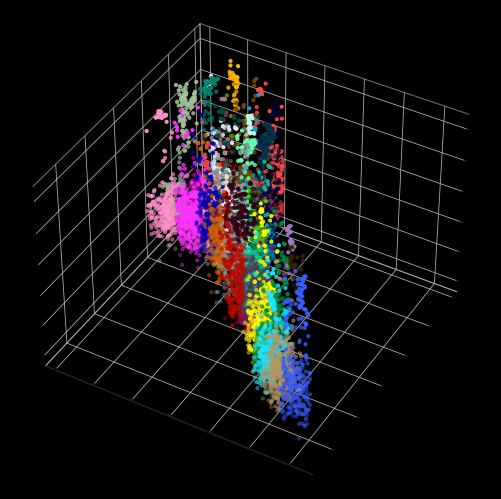

In [615]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
for i,patch in enumerate(np.sort(bm_cell_df['patch'].unique())):
    sub_group = bm_by_patch.get_group(patch)
    c = colors[i]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=10)
ax.view_init(-140, 60)
plt.tight_layout()

plt.savefig(r'.\figures\bm_007-13_patches.png')

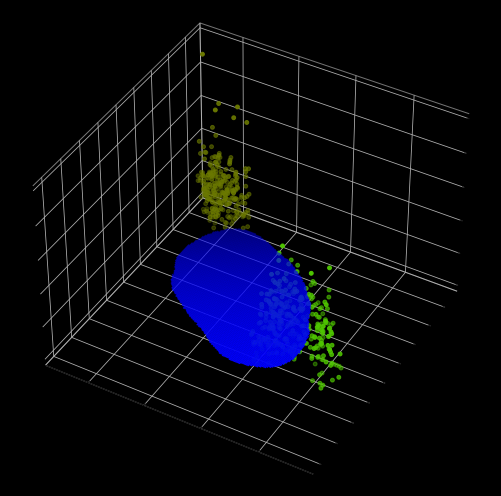

In [52]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
ax.scatter(dapi_row,,dapi_z,color='b',s=0.5)

# ax.scatter(bm_cell_df['row']*scale,bm_cell_df['col']*scale,bm_cell_df['z']*z_scale,'.',color='gray',s=1)
sub_group = bm_by_patch.get_group(19)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=colors[19],s=15)

sub_group = bm_by_patch.get_group(25)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=colors[25],s=15)

ax.view_init(-140, 60)
plt.tight_layout()

plt.savefig(r'.\figures\bm_007-13_patches 19 25.png')

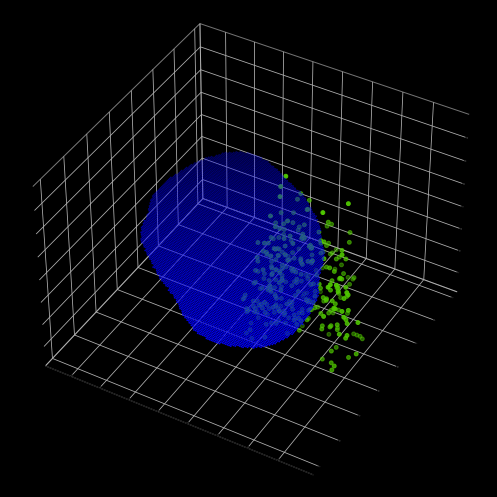

In [53]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

# ax.scatter(bm_cell_df['row']*scale,bm_cell_df['col']*scale,bm_cell_df['z']*z_scale,'.',color='gray',s=1)
sub_group = bm_by_patch.get_group(19)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=colors[19],s=15)

# sub_group = bm_by_patch.get_group(25)
# ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=colors[25],s=15)

ax.view_init(-140, 60)
plt.tight_layout()

plt.savefig(r'.\figures\bm_007-13_patches 19.png')

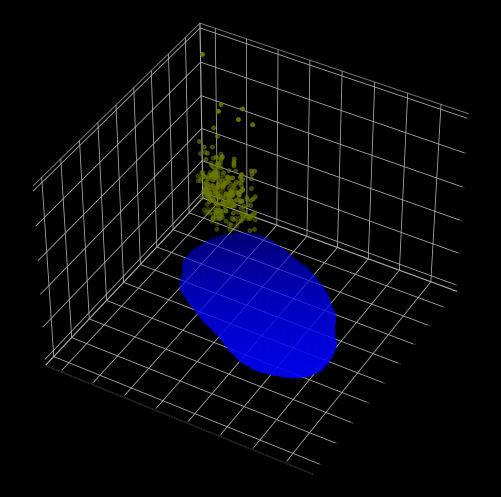

In [54]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

# ax.scatter(bm_cell_df['row']*scale,bm_cell_df['col']*scale,bm_cell_df['z']*z_scale,'.',color='gray',s=1)
# sub_group = bm_by_patch.get_group(19)
# ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=colors[19],s=15)

sub_group = bm_by_patch.get_group(25)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=colors[25],s=15)

ax.view_init(-140, 60)
plt.tight_layout()

plt.savefig(r'.\figures\bm_007-13_patches 25.png')

### Patch cluster

In [616]:
patch_cluster_colors = proxi_adata.uns['leiden_colors']

In [617]:
patch_center = {'row':[],'col':[],'z':[],'patch_id':[],'patch_cluster':[]}
for i,patch in enumerate(np.sort(bm_cell_df['patch'].unique())):
    sub_group = bm_by_patch.get_group(patch)
    patch_center['row'].append(sub_group['row'].mean()*scale)
    patch_center['col'].append(sub_group['col'].mean()*scale)
    patch_center['z'].append(sub_group['z'].mean()*z_scale)
    
    patch_id = sub_group['cellID'].unique()[0]+'_'+str(patch)
    patch_center['patch_id'].append(patch_id)
    patch_center['patch_cluster'].append(proxi_df.loc[patch_id,'cluster'])

In [618]:
patch_center = pd.DataFrame(patch_center)

In [619]:
patch_by_cluster = patch_center.groupby('patch_cluster')

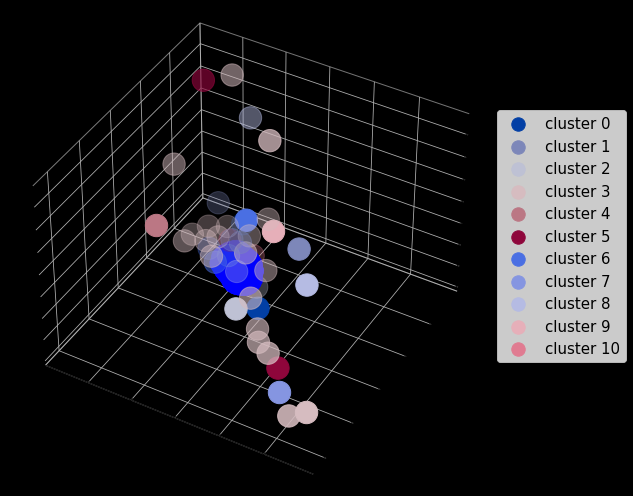

In [621]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
ax.scatter(dapi_row,dapi_col,dapi_z,s=1,color='b')
for i,cluster in enumerate(np.sort(patch_center['patch_cluster'].unique())):
    sub_group = patch_by_cluster.get_group(cluster)
    c = patch_cluster_colors[i]
    ax.scatter(sub_group['row'],sub_group['col'],sub_group['z'],'.',color=c,s=500,label='cluster '+str(cluster))
ax.view_init(-140, 60)
ax.legend(loc='upper left',bbox_to_anchor=(1,0.8),fontsize=15,markerscale=0.6)
plt.tight_layout()

plt.savefig(r'.\figures\bm_007-13_patches_clusters.png')

### patch proximity score

In [622]:
patch_ibsp_spp1 = []
patch_il6_col1a1 = []
for p in patch_center['patch_id'].tolist():
    patch_ibsp_spp1.append(proxi_df.loc[p,'IBSP_SPP1'])
    patch_il6_col1a1.append(proxi_df.loc[p,'COL1A1_IL6'])
patch_center.insert(loc=patch_center.shape[1],column='IBSP_SPP1',value=patch_ibsp_spp1)
patch_center.insert(loc=patch_center.shape[1],column='COL1A1_IL6',value=patch_il6_col1a1)

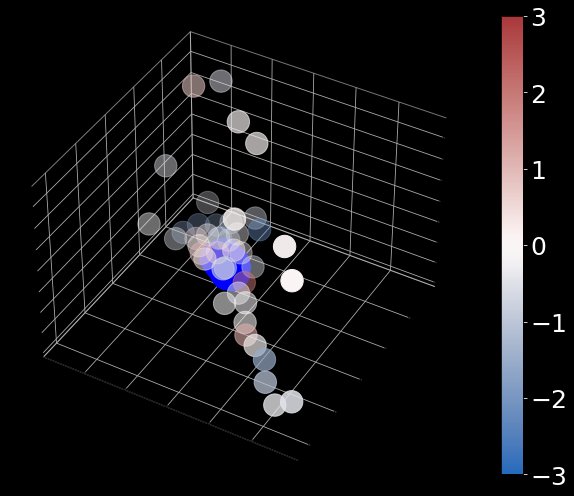

In [623]:
# IBSP_SPP1
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

im = ax.scatter(patch_center['row'],patch_center['col'],patch_center['z'],'.',s=500,
           c=patch_center['IBSP_SPP1'],cmap='vlag',vmin=-3,vmax=3)
ax.view_init(-140, 60)
# ax.legend(loc='upper left',bbox_to_anchor=(1,0.8),fontsize=15,markerscale=0.6)

cb = fig.colorbar(im, ax=ax)
cb.ax.yaxis.set_tick_params(color='#ffffff')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='#ffffff',fontsize=25)

plt.tight_layout()

plt.savefig(r'.\figures\bm_007_13_ibsp_spp1.png')

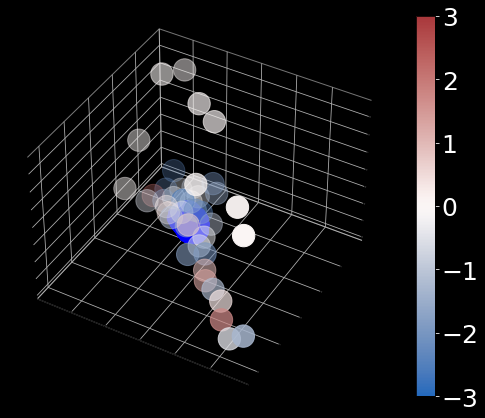

In [624]:
# IL6_COL1A1
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

im = ax.scatter(patch_center['row'],patch_center['col'],patch_center['z'],'.',s=500,
           c=patch_center['COL1A1_IL6'],cmap='vlag',vmin=-3,vmax=3)
ax.view_init(-140, 60)
# ax.legend(loc='upper left',bbox_to_anchor=(1,0.8),fontsize=15,markerscale=0.6)

cb = fig.colorbar(im, ax=ax)
cb.ax.yaxis.set_tick_params(color='#ffffff')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='#ffffff',fontsize=25)

plt.savefig(r'.\figures\bm_007_13_col1a1_il6.png')

# Plot uc cell patch cluster example

## UC dapi image

In [441]:
dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\imgs\031_image.tif')
dapi_mip = dapi_mip[2,:,:]

mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\masks\031_mask.tif')
mask = (mask==2).astype('int')
masked_dapi = mask * dapi_mip

In [442]:
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre
coor = np.where(dapi_mask)

In [443]:
dapi_row = coor[0].astype('float') * scale
dapi_col = coor[1].astype('float') * scale
dapi_z = 11 * z_scale

## Load data and plot

In [444]:
uc_cell_df = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df\uc_031_02.csv',index_col=0)
uc_cell_adata = sc.read_h5ad(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_adata\uc_031_02.h5ad')

In [445]:
colors = uc_cell_adata.uns['leiden_colors']

In [446]:
uc_by_patch = uc_cell_df.groupby('patch')

### raw rna plot

In [447]:
uc_by_gene = uc_cell_df.groupby('gene')

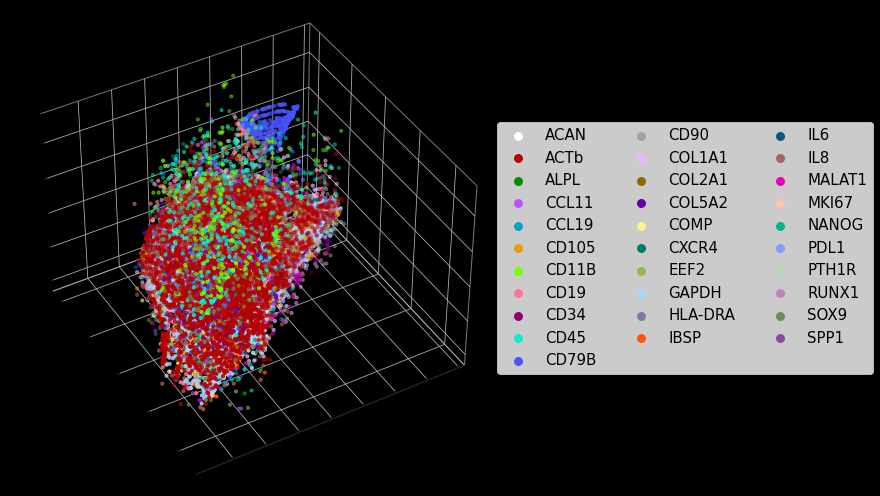

In [449]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
for g in genes:
    sub_group = uc_by_gene.get_group(g)
    c = gene_color_dict[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=10,label=g)
ax.view_init(-140, -60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=3,fontsize=15,markerscale=2.5)

plt.tight_layout()

plt.savefig(r'.\figures\uc_031_02_raw_rna.png',dpi=300)

### patch dots

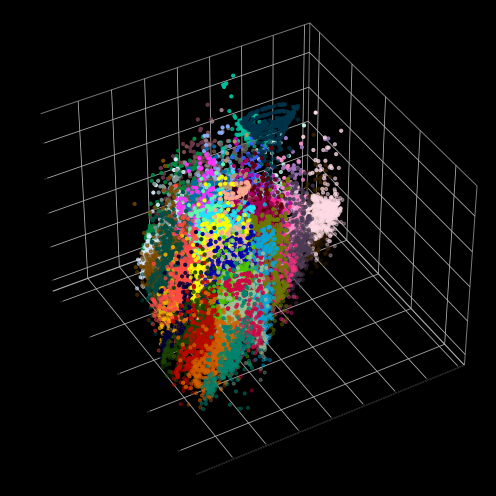

In [365]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

for i,patch in enumerate(np.sort(uc_cell_df['patch'].unique())):
    sub_group = uc_by_patch.get_group(patch)
    c = colors[i]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=10)
ax.view_init(-140, -60)
plt.tight_layout()

plt.savefig(r'.\figures\uc_031-02_patches.png')

In [366]:
patch_center = {'row':[],'col':[],'z':[],'patch_id':[],'patch_cluster':[]}
for i,patch in enumerate(np.sort(uc_cell_df['patch'].unique())):
    sub_group = uc_by_patch.get_group(patch)
    patch_center['row'].append(sub_group['row'].mean()*scale)
    patch_center['col'].append(sub_group['col'].mean()*scale)
    patch_center['z'].append(sub_group['z'].mean()*z_scale)
    
    patch_id = sub_group['cellID'].unique()[0]+'_'+str(patch)
    patch_center['patch_id'].append(patch_id)
    patch_center['patch_cluster'].append(proxi_df.loc[patch_id,'cluster'])

In [367]:
patch_center = pd.DataFrame(patch_center)

In [368]:
patch_by_cluster = patch_center.groupby('patch_cluster')

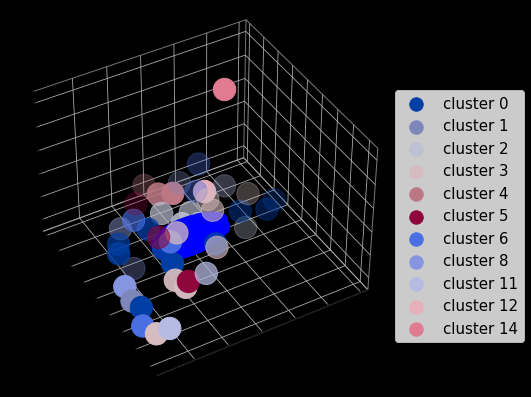

In [369]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

for i,cluster in enumerate(np.sort(patch_center['patch_cluster'].unique())):
    sub_group = patch_by_cluster.get_group(cluster)
    c = patch_cluster_colors[i]
    ax.scatter(sub_group['row'],sub_group['col'],sub_group['z'],'.',color=c,s=500,label='cluster '+str(cluster))
ax.view_init(-140, -60)
ax.legend(loc='upper left',bbox_to_anchor=(1,0.8),fontsize=15,markerscale=0.6)
# plt.tight_layout()

plt.savefig(r'.\figures\uc_031-02_patches_clusters.png')

In [390]:
'CD19_CXCR4' in proxi_df.columns.tolist()

True

In [370]:
patch_ibsp_spp1 = []
patch_il6_col1a1 = []
patch_cd19_cxcr4 = []
for p in patch_center['patch_id'].tolist():
    patch_ibsp_spp1.append(proxi_df.loc[p,'IBSP_SPP1'])
    patch_il6_col1a1.append(proxi_df.loc[p,'COL1A1_IL6'])
    patch_cd90_cxcr4.append(proxi_df.loc[p,'CD19_CXCR4'])
patch_center.insert(loc=patch_center.shape[1],column='IBSP_SPP1',value=patch_ibsp_spp1)
patch_center.insert(loc=patch_center.shape[1],column='COL1A1_IL6',value=patch_il6_col1a1)
patch_center.insert(loc=patch_center.shape[1],column='CD19_CXCR4',value=patch_cd19_cxcr4)

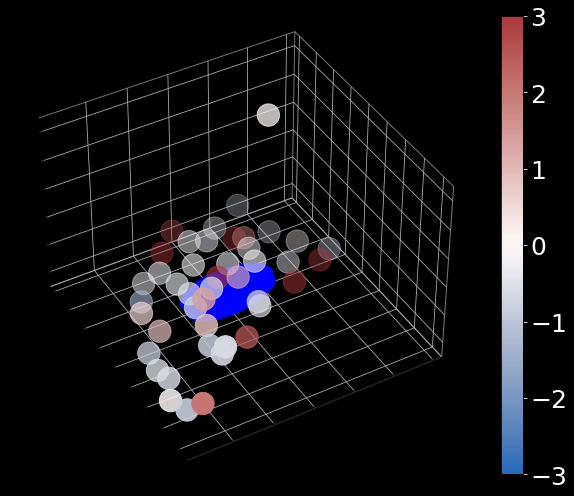

In [372]:
# IBSP_SPP1
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

im = ax.scatter(patch_center['row'],patch_center['col'],patch_center['z'],'.',s=500,
           c=patch_center['IBSP_SPP1'],cmap='vlag',vmin=-3,vmax=3)
ax.view_init(-140, -60)
# ax.legend(loc='upper left',bbox_to_anchor=(1,0.8),fontsize=15,markerscale=0.6)

cb = fig.colorbar(im, ax=ax)
cb.ax.yaxis.set_tick_params(color='#ffffff')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='#ffffff',fontsize=25)

plt.tight_layout()

plt.savefig(r'.\figures\UC_031_02_ibsp_spp1.png')

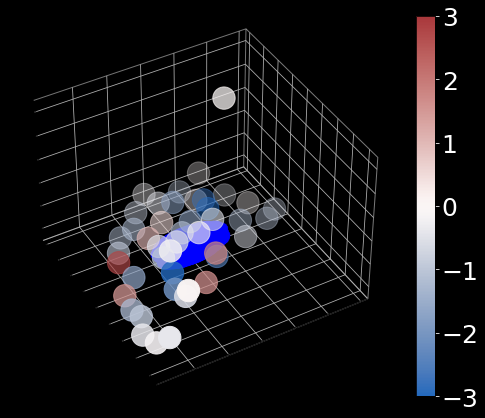

In [373]:
# IL6_COL1A1
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

im = ax.scatter(patch_center['row'],patch_center['col'],patch_center['z'],'.',s=500,
           c=patch_center['COL1A1_IL6'],cmap='vlag',vmin=-3,vmax=3)
ax.view_init(-140, -60)
# ax.legend(loc='upper left',bbox_to_anchor=(1,0.8),fontsize=15,markerscale=0.6)

cb = fig.colorbar(im, ax=ax)
cb.ax.yaxis.set_tick_params(color='#ffffff')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='#ffffff',fontsize=25)

plt.savefig(r'.\figures\uc_031_02_col1a1_il6.png')

# Mean distance of each patch cluster to center of cell

In [450]:
from scipy.spatial.distance import cdist

In [451]:
proxi_df.shape

(25441, 482)

In [452]:
cell_id = [0] * len(proxi_df.index.tolist())
for i,index in enumerate(proxi_df.index.tolist()):
    temp = index.split('_')
    cell_id[i] = temp[0]+'_'+temp[1]+'_'+temp[2]

In [453]:
proxi_df.insert(loc=proxi_df.shape[1],column='cellID',value=cell_id)

ValueError: cannot insert cellID, already exists

In [454]:
proxi_df.head()

ACAN_ACTb  ACAN_ALPL  ACAN_CCL11  ACAN_CCL19  ACAN_CD105  \
bm_001_01_0   0.000000   0.000000    0.000000    0.000000    2.848236   
bm_001_01_1   0.000000   0.000000    0.000000    0.000000    0.000000   
bm_001_01_2   0.000000   0.000000    0.848949    0.000000   -0.968066   
bm_001_01_3   0.000000  -0.280918    0.000000   -0.252646   -0.365896   
bm_001_01_4  -0.198547  -0.262222    0.000000    3.404948    0.836933   

             ACAN_CD11B  ACAN_CD19  ACAN_CD34  ACAN_CD45  ACAN_CD79B  ...  \
bm_001_01_0    0.000000  -1.133975  -0.945549        0.0    0.000000  ...   
bm_001_01_1    0.000000   0.000000   0.000000        0.0    0.000000  ...   
bm_001_01_2    0.000000   0.000000   2.190913        0.0    0.297229  ...   
bm_001_01_3   -0.298339  -0.400994  -0.730901        0.0    0.000000  ...   
bm_001_01_4   -0.385988  -0.463018  -0.473670        0.0    0.000000  ...   

             PTH1R_RUNX1  PTH1R_SOX9  PTH1R_SPP1  RUNX1_RUNX1  RUNX1_SOX9  \
bm_001_01_0     0.000000    0.000000    0.000000     0.000000    0.000000   
bm_001_01_1    -1.039785    0.610487   -1.070801     0.000000   -0.333996   
bm_001_01_2    -0.654131   -0.693962    0.000000     0.000000   -0.229416   
bm_001_01_3     0.000000    0.000000    0.000000     0.000000    0.000000   
bm_001_01_4     0.000000    0.000000    0.000000    -0.205449   -0.278070   

             RUNX1_SPP1  SOX9_SPP1  SPP1_SPP1  cluster     cellID  
bm_001_01_0     0.00000   0.000000   0.000000        0  bm_001_01  
bm_001_01_1     2.56051  -0.389507   0.000000        5  bm_001_01  
bm_001_01_2     0.00000   0.000000   0.000000        1  bm_001_01  
bm_001_01_3     0.00000   0.000000   5.843122        9  bm_001_01  
bm_001_01_4     0.00000   0.000000   0.000000        0  bm_001_01  

[5 rows x 482 columns]

In [395]:
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df'

In [458]:
# Compute distance from center of patch to center of cell
# combine distance and cluster into 1 dataframe for statistics

patch_id = []
d = []
patch_cluster = []

for c in tqdm(cell_id):
    cell_df = pd.read_csv(os.path.join(cell_df_dir,c+'.csv'),index_col=0)
    cell_center = np.array([cell_df['row'].mean()*scale,cell_df['col'].mean()*scale,cell_df['z'].mean()*z_scale])
    cell_by_patch = cell_df.groupby('patch')
    patches = np.sort(cell_df['patch'].unique())
    
    data = cell_df.values[:,:3]
    data[:,0] = data[:,0]*scale
    data[:,1] = data[:,1]*scale
    data[:,2] = data[:,2]*z_scale
    
    norm_factor = 1
    
    patch_centers = []
    for p in patches:
        patch_df = cell_by_patch.get_group(p)
        patch_centers.append(np.array([patch_df['row'].mean()*scale,patch_df['col'].mean()*scale,patch_df['z'].mean()*z_scale]))
    patch_centers = np.array(patch_centers)
    cell_size = np.max(cdist(patch_centers,patch_centers))
    for patch_center in patch_centers:
        distance = np.sqrt(np.sum(patch_center - cell_center)**2)
        norm_d = distance / cell_size
        patch_id.append(c+'_'+str(p))
        d.append(norm_d)
        patch_cluster.append(proxi_df.loc[c+'_'+str(p),'cluster'])

100%|████████████████████████████████████████████████████████████████████████████| 25441/25441 [17:44<00:00, 23.90it/s]


# Statistics and boxplots

In [460]:
from statannot import add_stat_annotation
import seaborn as sns

In [472]:
data = {'patch_id':patch_id, 'Cluster':patch_cluster, 'Distance':d}
# for i in range(len(data['Cluster'])):
#     data['Cluster'][i] = int(data['Cluster'][i].split(' ')[1])
cell_types = []
for item in data['patch_id']:
    cell_types.append('H'+item.split('_')[0].upper())
data['Cell Types'] = cell_types
df = pd.DataFrame(data)

In [473]:
df.drop(df.loc[df['Cluster']==13].index, inplace=True)

In [474]:
df.head()

patch_id  Cluster  Distance Cell Types
0  bm_001_01_22        0  0.222880        HBM
1  bm_001_01_22        0  0.025361        HBM
2  bm_001_01_22        0  0.209165        HBM
3  bm_001_01_22        0  0.151576        HBM
4  bm_001_01_22        0  0.077209        HBM

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_HBM v.s. 9_HUC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=4.640e+07
10_HBM v.s. 10_HUC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.803e-84 U_stat=3.050e+07
11_HBM v.s. 11_HUC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.592e-34 U_stat=1.613e+08
12_HBM v.s. 12_HUC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.027e-07 U_stat=7.956e+07
14_HBM v.s. 14_HUC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.657e+08
8_HBM v.s. 8_HUC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.462e-111 U_stat=4.837e+07
1_HBM v.s. 1_HUC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.444e-20 U_stat=1.205e+09
0_HBM v.s. 0_HU

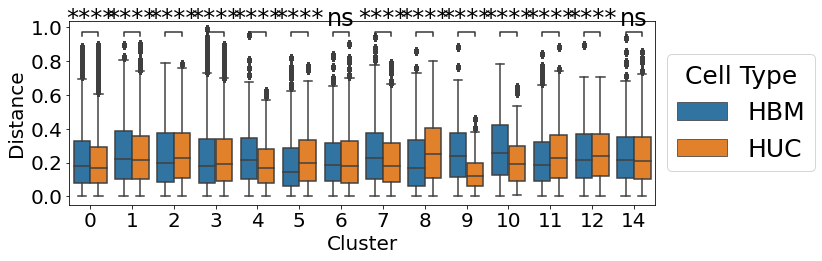

In [476]:
hue_order = ['HBM','HUC']
order = np.sort(df['Cluster'].unique())
box_pairs = [((o,'HBM'),(o,'HUC')) for o in order]
with rc_context({'font.size':20}):
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    sns.boxplot(data=df, hue='Cell Types', x='Cluster', y='Distance',order=order,hue_order=hue_order, ax=ax)
    add_stat_annotation(ax, data=df, hue='Cell Types', x='Cluster', y='Distance', order=order, hue_order=hue_order,
                        box_pairs=box_pairs,
                        test='Mann-Whitney', text_format='star',
                        loc='outside', line_offset=-0.08, verbose=2, fontsize='large')
    ax.legend(title='Cell Type', fontsize=25, title_fontsize=25, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_yticklabels(['-6','-4','-2','0','2','4','6','8','10'],fontsize=15,rotation=90)
    # ax.yaxis.tick_right()
    # ax.yaxis.set_label_position("right")

    # ax.set_ylabel('Proximity score',fontsize=22, rotation=90)

    # ax.set_xticklabels(['THBS1_FBN2','THBS1_SRRM2','FBN2_SRRM2'],fontsize=22,rotation=90)
    # ax.set_xlabel('')
    # ax.get_legend().remove()

    plt.tight_layout()
    plt.savefig(r'.\figures\cluster normalized distance comparison.png',dpi=300)

# defining features of patch clusters

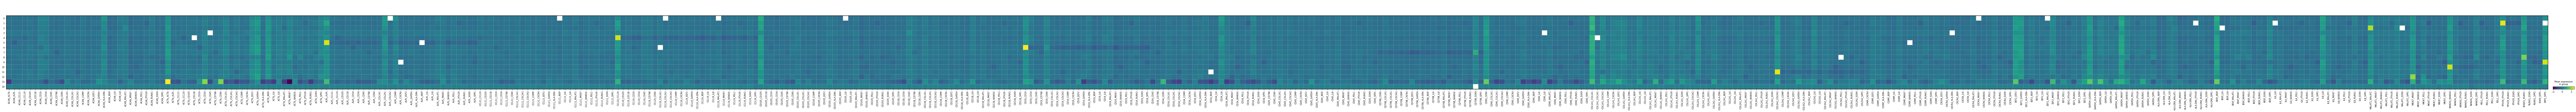

In [628]:
sc.pl.matrixplot(proxi_adata,var_names=proxi_adata.var_names,groupby='leiden',log=True)

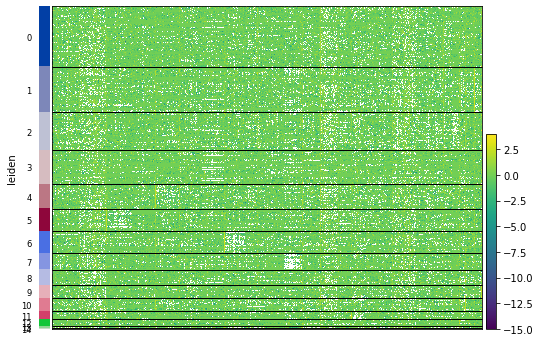

In [627]:
sc.pl.heatmap(proxi_adata, var_names=proxi_adata.var_names,groupby='leiden',log=True)

In [235]:
sc.tl.rank_genes_groups(proxi_adata,groupby='leiden')

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


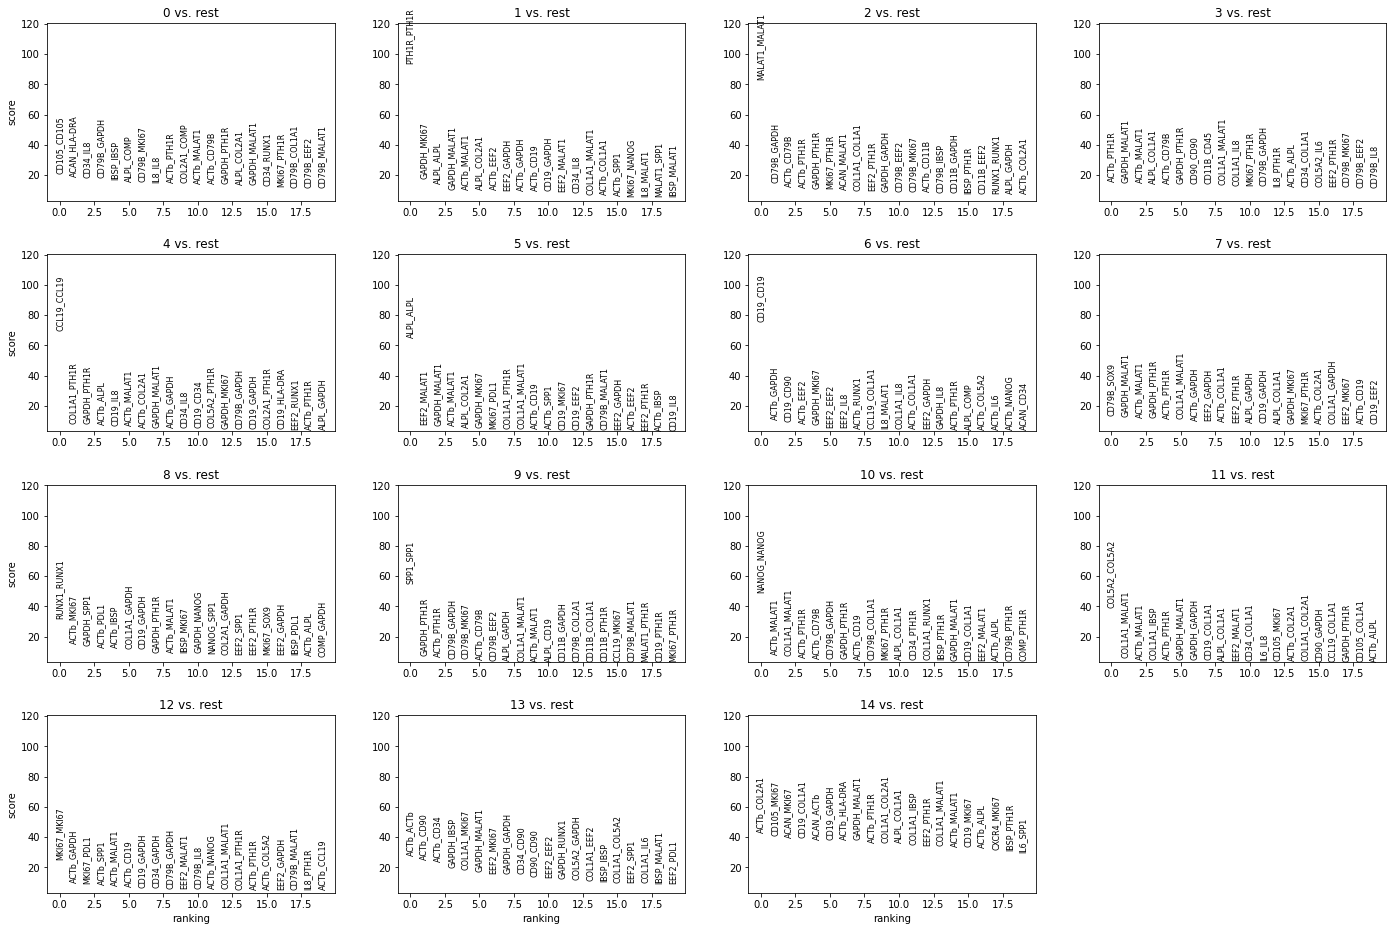

In [459]:
# with rc_context({'figure.figsize':(7,5)}):
sc.pl.rank_genes_groups(proxi_adata,groupby='leiden')

In [260]:
proxi_df

ACAN_ACTb  ACAN_ALPL  ACAN_CCL11  ACAN_CCL19  ACAN_CD105  \
bm_001_01_0    0.000000   0.000000    0.000000    0.000000    2.848236   
bm_001_01_1    0.000000   0.000000    0.000000    0.000000    0.000000   
bm_001_01_2    0.000000   0.000000    0.848949    0.000000   -0.968066   
bm_001_01_3    0.000000  -0.280918    0.000000   -0.252646   -0.365896   
bm_001_01_4   -0.198547  -0.262222    0.000000    3.404948    0.836933   
...                 ...        ...         ...         ...         ...   
uc_047_05_46  -0.892481  -0.241702   -0.740149   -0.147904    4.127215   
uc_047_05_47  -1.753374  -0.306139    0.000000   -0.594225   -0.872577   
uc_047_05_48   0.000000   0.000000    0.000000    0.000000    0.000000   
uc_047_05_49  -1.193224  -0.274122   -0.386556    0.000000   -0.467144   
uc_047_05_50  -0.934049   1.677687    2.025138   -0.185695   -0.204559   

              ACAN_CD11B  ACAN_CD19  ACAN_CD34  ACAN_CD45  ACAN_CD79B  ...  \
bm_001_01_0     0.000000  -1.133975  -0.945549   0.000000    0.000000  ...   
bm_001_01_1     0.000000   0.000000   0.000000   0.000000    0.000000  ...   
bm_001_01_2     0.000000   0.000000   2.190913   0.000000    0.297229  ...   
bm_001_01_3    -0.298339  -0.400994  -0.730901   0.000000    0.000000  ...   
bm_001_01_4    -0.385988  -0.463018  -0.473670   0.000000    0.000000  ...   
...                  ...        ...        ...        ...         ...  ...   
uc_047_05_46   -0.166987  -0.148583  -0.872376  -0.850557   -1.094560  ...   
uc_047_05_47   -0.400392  -0.804755  -0.488768  -1.069667   -0.542718  ...   
uc_047_05_48    0.000000   0.000000   0.000000   0.000000    0.000000  ...   
uc_047_05_49   -0.361698   2.846123  -0.415236  -0.290445   -0.241675  ...   
uc_047_05_50   -0.157481  -0.430803  -0.173032  -0.100504    0.000000  ...   

              PTH1R_RUNX1  PTH1R_SOX9  PTH1R_SPP1  RUNX1_RUNX1  RUNX1_SOX9  \
bm_001_01_0      0.000000    0.000000    0.000000     0.000000    0.000000   
bm_001_01_1     -1.039785    0.610487   -1.070801     0.000000   -0.333996   
bm_001_01_2     -0.654131   -0.693962    0.000000     0.000000   -0.229416   
bm_001_01_3      0.000000    0.000000    0.000000     0.000000    0.000000   
bm_001_01_4      0.000000    0.000000    0.000000    -0.205449   -0.278070   
...                   ...         ...         ...          ...         ...   
uc_047_05_46    -0.263230    0.000000   -0.700165    -0.112333    0.000000   
uc_047_05_47    -0.438613    0.000000   -0.578944     6.673206    0.000000   
uc_047_05_48     0.000000    0.000000    0.000000     0.000000    0.000000   
uc_047_05_49    -0.525820   -0.372455   -0.542270    -0.474058    1.780727   
uc_047_05_50    -0.288173    0.000000    0.000000    -0.339013    0.000000   

              RUNX1_SPP1  SOX9_SPP1  SPP1_SPP1  cluster     cellID  
bm_001_01_0     0.000000   0.000000   0.000000        0  bm_001_01  
bm_001_01_1     2.560510  -0.389507   0.000000        5  bm_001_01  
bm_001_01_2     0.000000   0.000000   0.000000        1  bm_001_01  
bm_001_01_3     0.000000   0.000000   5.843122        9  bm_001_01  
bm_001_01_4     0.000000   0.000000   0.000000        0  bm_001_01  
...                  ...        ...        ...      ...        ...  
uc_047_05_46    1.842718   0.000000   8.325613        2  uc_047_05  
uc_047_05_47   -0.399104   0.000000  -0.352473        8  uc_047_05  
uc_047_05_48    0.000000   0.000000   6.739067        6  uc_047_05  
uc_047_05_49    0.922715  -0.521675  -0.487505        0  uc_047_05  
uc_047_05_50    0.000000   0.000000   0.000000        2  uc_047_05  

[25441 rows x 482 columns]

## Average gene network per cluster

In [511]:
proxi_by_cluster = proxi_df.groupby('cluster')
clusters = np.sort(proxi_by_cluster['cluster'].unique()).astype('float')

In [513]:
by_cluster_gnn = []
for c in clusters:
    sub_group = proxi_by_cluster.get_group(c)
    sub_group = sub_group.drop(columns=['cluster','cellID'])
    by_cluster_gnn.append(sub_group.mean())

In [526]:
genes = genes.tolist()

In [530]:
by_cluster_gnn_square = []
for item in by_cluster_gnn:
    temp = np.zeros((len(genes),len(genes)))
    l = item.index.tolist()
    for pair in l:
        [g1,g2] = pair.split('_')
        idx1 = genes.index(g1)
        idx2 = genes.index(g2)
        temp[idx1,idx2] = item[pair]
        temp[idx2,idx1] = item[pair]
    temp = pd.DataFrame(temp,columns=genes,index=genes)
    by_cluster_gnn_square.append(temp)

In [534]:
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\3d_spagnn\spagnn\results\mean cluster networks'

for i in range(len(by_cluster_gnn_square)):
    by_cluster_gnn_square[i].to_csv(os.path.join(out_dir,'cluster '+str(i)+'.csv'))